In [1]:
import pandas as pd
import numpy as np

import os
from __future__ import print_function
import codecs
import pickle
import json

import numpy as np
import pandas as pd
import random

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.manifold import MDS

from scipy.cluster.hierarchy import ward, dendrogram

import nltk
from nltk.stem.snowball import SnowballStemmer
import re
import mpld3

import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict

In [2]:
rating_headers = ['doc_id','hotel_name','hotel_url','street','city','state','country','zip','class','price','num_reviews','CLEANLINESS','ROOM','SERVICE','LOCATION','VALUE', 'COMFORT','overall_ratingsource']

In [3]:
df_hotels_las_vegas = pd.read_csv('data/las-vegas.csv', names = rating_headers).drop(0)

In [4]:
df_hotels_las_vegas.head()

,doc_id,hotel_name,hotel_url,street,city,state,country,zip,class,price,num_reviews,CLEANLINESS,ROOM,SERVICE,LOCATION,VALUE,COMFORT,overall_ratingsource
1,usa_nevada_las-vegas_staybridge_suites_las_vegas,staybridge suites las vegas,http://www.tripadvisor.com/ShowUserReviews-g45...,-1,las vegas,nv,usa,89118,-1,-1,113,4.884615384615385,4.913461538461538,4.721153846153846,4.259615384615385,4.855769230769231,0.0,4.726923076923077
2,usa_nevada_las-vegas_four_seasons_hotel_las_vegas,four seasons hotel las vegas,http://www.tripadvisor.com/ShowUserReviews-g45...,-1,las vegas,nv,usa,89119,-1,-1,427,4.823321554770318,4.614840989399293,4.692579505300353,4.219081272084805,4.339222614840989,0.0,4.5378091872791515
3,usa_nevada_las-vegas_desert_rose_resort,desert rose resort,http://www.tripadvisor.com/ShowUserReviews-g45...,-1,las vegas,nv,usa,89119,-1,-1,325,4.601328903654485,4.614617940199335,4.548172757475083,4.46843853820598,4.707641196013289,0.0,4.588039867109634
4,usa_nevada_las-vegas_signature_at_mgm_grand,signature at mgm grand,http://www.tripadvisor.com/ShowUserReviews-g45...,-1,las vegas,nv,usa,89109,-1,-1,324,4.7574750830564785,4.760797342192691,4.45514950166113,4.129568106312292,4.45514950166113,0.0,4.511627906976744
5,usa_nevada_las-vegas_skylofts_at_mgm_grand,skylofts at mgm grand,http://www.tripadvisor.com/ShowUserReviews-g45...,-1,las vegas,nv,usa,89109,-1,-1,77,4.863636363636363,4.893939393939394,4.803030303030303,4.53030303030303,4.378787878787879,0.0,4.693939393939393


In [5]:
df_hotels_las_vegas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 1 to 230
Data columns (total 18 columns):
doc_id                  230 non-null object
hotel_name              230 non-null object
hotel_url               230 non-null object
street                  230 non-null object
city                    230 non-null object
state                   230 non-null object
country                 230 non-null object
zip                     230 non-null object
class                   230 non-null object
price                   230 non-null object
num_reviews             230 non-null object
CLEANLINESS             230 non-null object
ROOM                    230 non-null object
SERVICE                 230 non-null object
LOCATION                230 non-null object
VALUE                   230 non-null object
COMFORT                 230 non-null object
overall_ratingsource    230 non-null object
dtypes: object(18)
memory usage: 34.1+ KB


In [6]:
# convert overall_ratingsource to float
df_hotels_las_vegas['overall_ratingsource'] = df_hotels_las_vegas['overall_ratingsource'].astype(float)

In [12]:
# convert num_reviews to int
df_hotels_las_vegas['num_reviews'] = df_hotels_las_vegas['num_reviews'].astype(int)

In [7]:
# get rid of all hotels that are ratings below 4
lower_2 = df_hotels_las_vegas['overall_ratingsource'] > 2
df_hotels_las_vegas = df_hotels_las_vegas[lower_2]

In [8]:
df_hotels_las_vegas.count()

doc_id                  198
hotel_name              198
hotel_url               198
street                  198
city                    198
state                   198
country                 198
zip                     198
class                   198
price                   198
num_reviews             198
CLEANLINESS             198
ROOM                    198
SERVICE                 198
LOCATION                198
VALUE                   198
COMFORT                 198
overall_ratingsource    198
dtype: int64

''

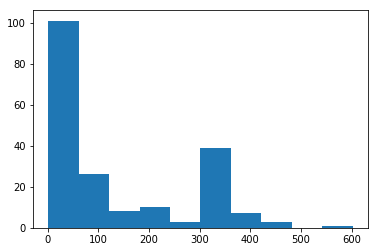

In [13]:
plt.hist(df_hotels_las_vegas['num_reviews'])
;

In [14]:
# average reviews
df_hotels_las_vegas['num_reviews'].mean()

132.6919191919192

''

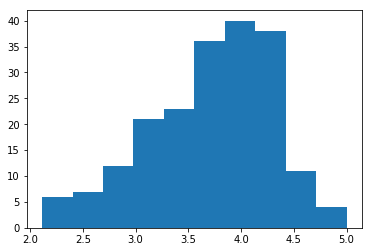

In [9]:
plt.hist(df_hotels_las_vegas['overall_ratingsource'])
;

In [10]:
# get all file_names ids
file_names = os.listdir('data/las-vegas/')

In [11]:
for name in file_names:
    if "." in name:
        print(name)

In [12]:
file_names[:10]

['usa_nevada_las-vegas_the_resort_on_mount_charleston',
 'usa_nevada_las-vegas_budget_suites_of_america_tropicana_i_15',
 'usa_nevada_las-vegas_siena_suites',
 'usa_nevada_las-vegas_hard_rock_hotel_and_casino',
 'usa_nevada_las-vegas_best_western_nellis_motor_inn',
 'usa_nevada_las-vegas_eastside_cannery_casino_hotel',
 'usa_nevada_las-vegas_town_and_country_manor_iii',
 'usa_nevada_las-vegas_tuscany_suites_casino',
 'usa_nevada_las-vegas_south_point_hotel_casino_and_spa',
 'usa_nevada_las-vegas_atrium_suites_hotel_las_vegas']

In [13]:
def get_hotel_reviews(file_name):
    
    review_headers = ['date', 'review_title', 'full_review', 'nan']
    
    reviews = []
    
    df = pd.read_csv('data/las-vegas/' + file_name, 
                     names=review_headers ,sep='\t', encoding='latin-1').drop('nan', axis=1)
    
    for review in df['full_review']:
        reviews.append(str(review))
        
    corpus = " ".join(reviews)
    
    return file_name, corpus

In [14]:
# # test one filename
# h, r = get_hotel_reviews('usa_nevada_las-vegas_the_orleans_hotel_casino')

In [15]:
# type(r)

In [16]:
start_name_index = len('usa_nevada_las-vegas_')

In [17]:
hotel_names = []
hotel_reviews = []

for idx, name in enumerate(file_names):
    # for some reason file #31 isn't working
    if idx == 31:
        continue
    hotel, all_reviews = get_hotel_reviews(name)
    hotel_names.append(hotel[start_name_index:])
    hotel_reviews.append(all_reviews)

In [18]:
len(hotel_names), len(hotel_reviews)

(205, 205)

In [19]:
print ('There are {} hotels in the dataset.'.format(len(hotel_names)))

There are 205 hotels in the dataset.


In [20]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [21]:
# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

In [22]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [23]:
# If you are running this process for the first time, uncomment below:
hotel_vocab_stemmed = []
hotel_vocab_tokenized = []

for i in hotel_reviews:
    allwords_stemmed = tokenize_and_stem(i)
    hotel_vocab_stemmed.extend(allwords_stemmed)
    allwords_tokenized = tokenize_only(i)
    hotel_vocab_tokenized.extend(allwords_tokenized)

In [24]:
len(hotel_vocab_stemmed), len(hotel_vocab_tokenized)

(5328015, 5328015)

In [25]:
%time hotel_vocab_frame = pd.DataFrame({'words': hotel_vocab_tokenized}, index = hotel_vocab_stemmed)

CPU times: user 989 ms, sys: 1.48 s, total: 2.47 s
Wall time: 2.88 s


In [26]:
hotel_vocab_frame.head()

,words
we,we
stop,stopped
by,by
the,the
resort,resort


### Tf-Idf and Document Similarity Measure

In [27]:
combined = list(zip(hotel_names, hotel_reviews))

In [28]:
# randomly shuffle the hotels, keeping the names in order with the reviews
random.shuffle(combined)
# retrieve hotel names and hotel reviews in the new order, after shuffling
hotel_names[:], hotel_reviews[:] = zip(*combined)

In [40]:
for testing purposes, you can use this snippet to run kmeans on 100 hotels of the whole corpus.
reviews_grouped = [hotel_reviews[i:i + 100] for i in range(0, len(hotel_reviews), 100)]
print ("There are {} hotels in our sample.".format(len(reviews_grouped[0])))

# # 200 -for testing purposes, you can use this snippet to run kmeans on 100 hotels of the whole corpus.
# reviews_grouped = [hotel_reviews[i:i + 200] for i in range(0, len(hotel_reviews), 200)]
# print ("There are {} hotels in our sample.".format(len(reviews_grouped[0])))

There are 200 hotels in our sample.


In [41]:
# initiate TfidfVectorizer instance with the set hyperparameters that were mentioned above
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1, 3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_grouped[0])
print(tfidf_matrix.shape)

CPU times: user 3min 26s, sys: 5.11 s, total: 3min 31s
Wall time: 3min 40s
(200, 5735)


In [31]:
# saving the matrix by dumping into a pickle file. set *protocol=2* if you are using python2
joblib.dump(tfidf_matrix,  'data/tfidf_matrix2.pkl')
#tfidf_matrix = joblib.load('tfidf_matrix2.pkl')

['data/tfidf_matrix2.pkl']

In [42]:
terms = tfidf_vectorizer.get_feature_names()
# calculate cosine similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

In [33]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

CPU times: user 8.5 s, sys: 77 ms, total: 8.57 s
Wall time: 8.79 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [34]:
#joblib.dump(km,  'doc_cluster.pkl')
clusters = km.labels_.tolist()
len(clusters)
# 100 hotels

100

In [35]:
ranks = []

for i in range(0,len(hotel_names)):
    ranks.append(i)

In [36]:
# every group has 1000 ramdonly shuffled hotels, change indeces
hotels = { 'hotel_name': hotel_names[:100], 'rank': ranks[:100], 'hotel_reviews': hotel_reviews[:100], 'cluster': clusters}

frame = pd.DataFrame(hotels, index = [clusters] , columns = ['rank', 'hotel_name', 'hotel_reviews', 'cluster'])

In [37]:
frame['cluster'].value_counts()

4    37
2    24
3    19
1    13
0     7
Name: cluster, dtype: int64

In [38]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    70.428571
1    48.923077
2    50.250000
3    49.842105
4    45.081081
Name: rank, dtype: float64

In [39]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % hotel_vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d hotels:" % i, end='')
    for title in frame.loc[i]['hotel_name'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'suite', b'budget', b'roach', b'office', b'dont', b'information', b'security', b'pets', b'extended', b'police', b'since', b'smelled', b'deposit', b'drug', b'months', b'cigarette', b'stains', b'extended', b'cheap', b'phone',

Cluster 0 hotels: the_suites_boulder_strip, super_8_las_vegas_boulder_highway, town_and_country_manor_iii, aruba_hotel, the_suites, budget_suites_of_america_north_rancho_drive, budget_suites_of_america_wynn,

Cluster 1 words: b'fremont', b'downtown', b'fremont', b'nugget', b'golden', b'tower', b'freemont', b'year', b'westerns', b'play', b'elevator', b'slot', b'golden', b'gamble', b'stay', b'queen', b'table', b'lovely', b'cheap', b'machines',

Cluster 1 hotels: las_vegas_club_casino_hotel, fitzgeralds_casino_hotel, el_cortez_hotel_casino, fremont_hotel_and_casino, ogden_house_motel, western_hotel_casino, golden_gate_hotel_casino, four_queens_hotel_and_casino, golden_nugget, best_western_main_street_inn, jerry_s_nugget, binio

In [43]:
# problem, vegas hotels might not be enough by itself